# Hybrid quantum-classical feed forward neural network for solving the TSP.

In [1]:
# !pip install -r requirements.txt

In [2]:
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import numpy as np
import sympy
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

2021-12-21 20:14:20.546790: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-21 20:14:20.548887: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## TSP 


In [3]:
class TSP:
    def __init__(self, number_of_cities, coords_range=(0, 10000)):
        self.number_of_cities = number_of_cities
        self.coords_range = coords_range
        self.cities_coords = self.get_cities()
        self.distance_matrix = self.calculate_distance_matrix()
        self.normalized_distance_matrix = self.normalize_distance_matrix()
    
    def get_cities(self):
        cities_coords = np.random.randint(self.coords_range[0], self.coords_range[1], size = (self.number_of_cities, 2))
        return cities_coords
           
    def normalize_cities(self):
        max_coords = np.amax(self.cities_coords, axis=0)
        normalized_cities_coords = np.divide(self.cities_coords, max_coords)
        return normalized_cities_coords

    def calculate_distance_between_points(self, point_A, point_B):
        return np.sqrt((point_A[0] - point_B[0])**2 + (point_A[1] - point_B[1])**2)
    
    def calculate_distance_matrix(self):
        distance_matrix = np.zeros((self.number_of_cities, self.number_of_cities))
        for i in range(self.number_of_cities):
            for j in range(i, self.number_of_cities):
                distance_matrix[i][j] = self.calculate_distance_between_points(self.cities_coords[i], self.cities_coords[j])
                distance_matrix[j][i] = distance_matrix[i][j]
        return distance_matrix 
    
    def normalize_distance_matrix(self):
        return np.divide(self.distance_matrix, np.max(self.distance_matrix))

##  QAOA

In [4]:
class QAOA_TSP:
    def __init__(self, tsp_instance, p=1, A_1=4, A_2=4, B=1):
        self.tsp_instance = tsp_instance
        self.qubits = cirq.GridQubit.rect(1, tsp_instance.number_of_cities**2)
        self.p = p
        self.weights = {'cost_weight': B, 
                        'constraint_each_visited': A_1, 
                        'constraint_each_visited_once': A_2}
        self.parameters = self.generate_sympy_parameters()
        self.cost_operator = self.create_cost_operator()
        self.circuit = self.create_qaoa_circuit()
    
    def calc_bit(self, i, t):
        return i + t * self.tsp_instance.number_of_cities
    
    def x(self, i, t):
        x = self.calc_bit(i, t)
        qubit = self.qubits[x]
        return cirq.PauliString(0.5, cirq.I(qubit)) - cirq.PauliString(0.5, cirq.Z(qubit))
        
    def create_hadamard_circuit_layer(self):
        hadamard_circuit_layer = cirq.Circuit()
        for qubit in self.qubits:
            hadamard_circuit_layer += cirq.H(qubit)
        return hadamard_circuit_layer
    
    def generate_sympy_parameters(self):
        return sympy.symbols('parameter_:%d'%(2*self.p))

    def create_cost_operator(self):
        A_1 = self.weights['constraint_each_visited']
        A_2 = self.weights['constraint_each_visited_once']
        B = self.weights['cost_weight']
        
        cost_of_constraint_each_visited = 0    
        for i in range(self.tsp_instance.number_of_cities):
            curr = 1
            for t in range(self.tsp_instance.number_of_cities):
                curr -= self.x(i, t)    
            cost_of_constraint_each_visited += np.power(curr, 2)
            
        cost_of_constraint_each_visited_once = 0
        for t in range(self.tsp_instance.number_of_cities):
            curr = 1
            for i in range(self.tsp_instance.number_of_cities):
                curr -= self.x(i, t)
            cost_of_constraint_each_visited_once += np.power(curr, 2)
        
        cost_of_visiting_cities = 0
        for i, j in itertools.permutations(range(0, self.tsp_instance.number_of_cities), 2):
            curr = 0
            for t in range(self.tsp_instance.number_of_cities):
                inc_t = t + 1
                if inc_t == self.tsp_instance.number_of_cities:
                    inc_t = 0
                curr += self.x(i, t) * self.x(j, inc_t)
            cost_of_visiting_cities += self.tsp_instance.normalized_distance_matrix[i][j] * curr 
        
        cost_operator = A_1 * cost_of_constraint_each_visited + \
                        A_2 * cost_of_constraint_each_visited_once + \
                        B * cost_of_visiting_cities
                
        return cost_operator
    
    def create_mixing_operator(self):
        mixing_operator = 0
        for qubit in self.qubits:
            mixing_operator += cirq.X(qubit)
        return mixing_operator

    def create_qaoa_circuit(self):
        hadamard_circuit_layer = self.create_hadamard_circuit_layer()
        cost_operator = self.create_cost_operator()
        mixing_operator = self.create_mixing_operator()
        parameterized_circuit_layers = tfq.util.exponential(operators = [cost_operator, mixing_operator] * self.p, 
                                                            coefficients = self.parameters)
        qaoa_circuit = hadamard_circuit_layer + parameterized_circuit_layers
        return qaoa_circuit

In [5]:
tsp_instance = TSP(4)
qaoa_tsp = QAOA_TSP(tsp_instance, p=10, A_1=4, A_2=4, B=1)

Display the circuit (sometimes it takes a little while...).

In [6]:
# from cirq.contrib.svg import SVGCircuit
# SVGCircuit(qaoa_tsp.circuit)

## Hybrid Quantum-Classical Feed Forward Neural Network

In [7]:
class QFFNN(tf.keras.layers.Layer):
  def __init__(self, parameters):
    super(QFFNN, self).__init__()
    self.parameters = parameters
    self.params_inp = tf.keras.Input(shape=(len(self.parameters),), name='input_layer')
    self.first_hidden = tf.keras.layers.Dense(len(self.parameters), name="hidden_layer")
    self.expectation = tfq.layers.Expectation(name="expectation_layer")
    

  def call(self, inputs):
    parameterized_circuit = inputs[0]
    cost_operator = inputs[1]
    initial_parameter_values = inputs[2]
    
    parameter_values = self.first_hidden(initial_parameter_values)
    expectation_value = self.expectation(parameterized_circuit,
                                       operators=cost_operator,
                                       symbol_names=self.parameters,
                                       symbol_values=parameter_values)

    return [parameter_values, expectation_value]

In [8]:
parametrized_circuit_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
operator_input = tf.keras.Input(shape=(1,), dtype=tf.dtypes.string)
parameters_input = tf.keras.Input(shape=(2 * qaoa_tsp.p,))

In [9]:
qffnn = QFFNN(qaoa_tsp.parameters)
output = qffnn([parametrized_circuit_input, operator_input, parameters_input])

In [10]:
model = tf.keras.Model(
              inputs=[
                  parametrized_circuit_input, 
                  operator_input, 
                  parameters_input
              ],
              outputs=[
                  output[0], # array of optimized 2p parameters
                  output[1], # expectation value
              ])

In [11]:
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss = tf.keras.losses.mean_absolute_error,
              loss_weights=[0, 1]
             )

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
qffnn (QFFNN)                   [(None, 20), (None,  420         input_1[0][0]                    
                                                                 input_2[0][0]                

In [13]:
circuit_tensor = tfq.convert_to_tensor([qaoa_tsp.circuit])
cost_operator_tensor = tfq.convert_to_tensor([qaoa_tsp.cost_operator])
initial_parameters = np.zeros((1, qaoa_tsp.p * 2)).astype(np.float32)

In [14]:
%%time
history = model.fit(
              x=[
                  circuit_tensor, 
                  cost_operator_tensor, 
                  initial_parameters, 
              ],
              y=[
                  np.zeros((1, qaoa_tsp.p * 2)),
                  np.zeros((1, 1)), # the closer to 0 the better the result
              ], 
              epochs=250,
              verbose=1)

2021-12-21 20:14:27.527930: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/250
1/1 [==============================] - 2s 2s/step - loss: 70.8359 - qffnn_loss: 0.0000e+00 - qffnn_1_loss: 70.8359
Epoch 2/250
1/1 [==============================] - 2s 2s/step - loss: 53.6952 - qffnn_loss: 0.0100 - qffnn_1_loss: 53.6952
Epoch 3/250
1/1 [==============================] - 2s 2s/step - loss: 39.8940 - qffnn_loss: 0.0114 - qffnn_1_loss: 39.8940
Epoch 4/250
1/1 [==============================] - 2s 2s/step - loss: 28.3136 - qffnn_loss: 0.0167 - qffnn_1_loss: 28.3136
Epoch 5/250
1/1 [==============================] - 2s 2s/step - loss: 20.6917 - qffnn_loss: 0.0219 - qffnn_1_loss: 20.6917
Epoch 6/250
1/1 [==============================] - 2s 2s/step - loss: 18.2556 - qffnn_loss: 0.0271 - qffnn_1_loss: 18.2556
Epoch 7/250
1/1 [==============================] - 1s 1s/step - loss: 18.4545 - qffnn_loss: 0.0315 - qffnn_1_loss: 18.4545
Epoch 8/250
1/1 [==============================] - 1s 1s/step - loss: 20.0995 - qffnn_loss: 0.0348 - qffnn_1_loss: 20.0995
Epoch 9/250


1/1 [==============================] - 1s 1s/step - loss: 7.4475 - qffnn_loss: 0.0955 - qffnn_1_loss: 7.4475
Epoch 68/250
1/1 [==============================] - 1s 1s/step - loss: 7.4035 - qffnn_loss: 0.0964 - qffnn_1_loss: 7.4035
Epoch 69/250
1/1 [==============================] - 1s 1s/step - loss: 7.3639 - qffnn_loss: 0.0972 - qffnn_1_loss: 7.3639
Epoch 70/250
1/1 [==============================] - 1s 1s/step - loss: 7.3217 - qffnn_loss: 0.0980 - qffnn_1_loss: 7.3217
Epoch 71/250
1/1 [==============================] - 1s 1s/step - loss: 7.2680 - qffnn_loss: 0.0987 - qffnn_1_loss: 7.2680
Epoch 72/250
1/1 [==============================] - 1s 1s/step - loss: 7.2147 - qffnn_loss: 0.0994 - qffnn_1_loss: 7.2147
Epoch 73/250
1/1 [==============================] - 1s 1s/step - loss: 7.1690 - qffnn_loss: 0.1001 - qffnn_1_loss: 7.1690
Epoch 74/250
1/1 [==============================] - 1s 1s/step - loss: 7.1254 - qffnn_loss: 0.1007 - qffnn_1_loss: 7.1254
Epoch 75/250
1/1 [===================

Epoch 134/250
1/1 [==============================] - 1s 1s/step - loss: 4.0190 - qffnn_loss: 0.1412 - qffnn_1_loss: 4.0190
Epoch 135/250
1/1 [==============================] - 1s 1s/step - loss: 3.9833 - qffnn_loss: 0.1419 - qffnn_1_loss: 3.9833
Epoch 136/250
1/1 [==============================] - 2s 2s/step - loss: 3.9502 - qffnn_loss: 0.1425 - qffnn_1_loss: 3.9502
Epoch 137/250
1/1 [==============================] - 3s 3s/step - loss: 3.9216 - qffnn_loss: 0.1431 - qffnn_1_loss: 3.9216
Epoch 138/250
1/1 [==============================] - 1s 1s/step - loss: 3.8985 - qffnn_loss: 0.1437 - qffnn_1_loss: 3.8985
Epoch 139/250
1/1 [==============================] - 1s 1s/step - loss: 3.8762 - qffnn_loss: 0.1443 - qffnn_1_loss: 3.8762
Epoch 140/250
1/1 [==============================] - 2s 2s/step - loss: 3.8577 - qffnn_loss: 0.1449 - qffnn_1_loss: 3.8577
Epoch 141/250
1/1 [==============================] - 3s 3s/step - loss: 3.8415 - qffnn_loss: 0.1454 - qffnn_1_loss: 3.8415
Epoch 142/250
1/

1/1 [==============================] - 2s 2s/step - loss: 3.2647 - qffnn_loss: 0.1569 - qffnn_1_loss: 3.2647
Epoch 201/250
1/1 [==============================] - 3s 3s/step - loss: 3.2634 - qffnn_loss: 0.1569 - qffnn_1_loss: 3.2634
Epoch 202/250
1/1 [==============================] - 1s 1s/step - loss: 3.2632 - qffnn_loss: 0.1569 - qffnn_1_loss: 3.2632
Epoch 203/250
1/1 [==============================] - 2s 2s/step - loss: 3.2605 - qffnn_loss: 0.1568 - qffnn_1_loss: 3.2605
Epoch 204/250
1/1 [==============================] - 2s 2s/step - loss: 3.2595 - qffnn_loss: 0.1568 - qffnn_1_loss: 3.2595
Epoch 205/250
1/1 [==============================] - 1s 1s/step - loss: 3.2574 - qffnn_loss: 0.1568 - qffnn_1_loss: 3.2574
Epoch 206/250
1/1 [==============================] - 1s 1s/step - loss: 3.2562 - qffnn_loss: 0.1568 - qffnn_1_loss: 3.2562
Epoch 207/250
1/1 [==============================] - 2s 2s/step - loss: 3.2553 - qffnn_loss: 0.1567 - qffnn_1_loss: 3.2553
Epoch 208/250
1/1 [===========

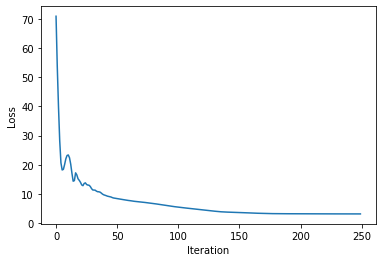

In [15]:
plt.plot(history.history['loss'])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

## Results

In [16]:
parameter_values = model.predict([circuit_tensor, cost_operator_tensor, initial_parameters])[0]
print(f"Parameter values:\n {parameter_values}")

Parameter values:
 [[-0.04974391  0.20074339  0.06534907  0.28605714 -0.03619862  0.24265523
  -0.03133952  0.26050368 -0.05093969  0.22009915 -0.11735244  0.21611243
  -0.1471545   0.1980844  -0.16294043  0.19584538 -0.16051918  0.1538376
  -0.2101574   0.12033881]]


In [17]:
samples_amount = 2**16
sample_layer = tfq.layers.Sample()
output = sample_layer(circuit_tensor, 
                      symbol_names=qaoa_tsp.parameters, 
                      symbol_values=parameter_values, 
                      repetitions=samples_amount)

In [18]:
from collections import Counter

results = output.numpy()[0].astype(str).tolist()
results_to_display = [''.join(result) for result in results]
correct_results = ("0001100001000010","0010010010000001","0100100000010010","1000000100100100","1000010000100001","0100001000011000","0001001001001000","0010000110000100","0100000110000010","0010100000010100","0001010000101000","0001100000100100","1000000101000010","1000001001000001","0100001010000001", "0100000100101000", "0010010000011000", "0100100000100001", "1000001000010100", "0001001010000100", "0001010010000010","0010000101001000", "1000010000010010", "0010100001000001")
counts = Counter(results_to_display)

correct_results_count = sum(counts[result] for result in correct_results)
print(f'Correct results: {round(correct_results_count / samples_amount * 100,2)}% \n')

print(f'bin \t\t\t\t occurences \t correct?')
for row in counts.most_common():
    is_correct = row[0] in (correct_results)
    print(f"{row[0][0:4]} \t {row[0][4:8]} \t {row[0][8:12]} \t {row[0][12:]} \t {row[1]} \t\t {is_correct}")

Correct results: 92.7% 

bin 				 occurences 	 correct?
0001 	 0100 	 0010 	 1000 	 2672 		 True
0010 	 1000 	 0001 	 0100 	 2672 		 True
1000 	 0010 	 0100 	 0001 	 2655 		 True
0001 	 0010 	 0100 	 1000 	 2647 		 True
0010 	 0100 	 0001 	 1000 	 2631 		 True
0001 	 1000 	 0010 	 0100 	 2627 		 True
1000 	 0001 	 0010 	 0100 	 2600 		 True
1000 	 0001 	 0100 	 0010 	 2599 		 True
0100 	 0001 	 1000 	 0010 	 2588 		 True
0100 	 1000 	 0001 	 0010 	 2580 		 True
0010 	 0100 	 1000 	 0001 	 2569 		 True
0100 	 0010 	 1000 	 0001 	 2548 		 True
0010 	 0001 	 1000 	 0100 	 2533 		 True
0001 	 1000 	 0100 	 0010 	 2528 		 True
1000 	 0100 	 0001 	 0010 	 2502 		 True
0100 	 0010 	 0001 	 1000 	 2498 		 True
1000 	 0100 	 0010 	 0001 	 2482 		 True
0100 	 1000 	 0010 	 0001 	 2451 		 True
0010 	 0001 	 0100 	 1000 	 2426 		 True
0001 	 0100 	 1000 	 0010 	 2409 		 True
0100 	 0001 	 0010 	 1000 	 2404 		 True
0001 	 0010 	 1000 	 0100 	 2396 		 True
1000 	 0010 	 0001 	 0100 	 2384 		 True
0

0100 	 1000 	 0100 	 1011 	 1 		 False
0100 	 1000 	 0110 	 0100 	 1 		 False
0100 	 1000 	 0111 	 0100 	 1 		 False
0100 	 1000 	 1001 	 0000 	 1 		 False
0100 	 1000 	 1011 	 0100 	 1 		 False
0100 	 1000 	 1111 	 0010 	 1 		 False
0100 	 1001 	 0000 	 0100 	 1 		 False
0100 	 1001 	 0000 	 1000 	 1 		 False
0100 	 1001 	 0000 	 1010 	 1 		 False
0100 	 1001 	 0001 	 0011 	 1 		 False
0100 	 1001 	 0010 	 1000 	 1 		 False
0100 	 1001 	 0100 	 0100 	 1 		 False
0100 	 1001 	 1010 	 1000 	 1 		 False
0100 	 1010 	 0001 	 0000 	 1 		 False
0100 	 1010 	 0001 	 0010 	 1 		 False
0100 	 1010 	 1000 	 0000 	 1 		 False
0100 	 1010 	 1000 	 0101 	 1 		 False
0100 	 1010 	 1000 	 1010 	 1 		 False
0100 	 1010 	 1100 	 1000 	 1 		 False
0100 	 1011 	 0000 	 0010 	 1 		 False
0100 	 1011 	 0010 	 1000 	 1 		 False
0100 	 1100 	 0001 	 0010 	 1 		 False
0100 	 1100 	 0010 	 0000 	 1 		 False
0100 	 1100 	 0010 	 0100 	 1 		 False
0100 	 1100 	 0100 	 0110 	 1 		 False
0100 	 1101 	 0000 	 1000